# MSFT Rewards Modeller

With the new Total Rewards portal, Microsoft no longer includes their detailed "modeller" to estimate your compensation over time. This notebook brings it back.

## How to Use This

1. Download VS Code and the Python extension, and open this notebook. (Or load this in any Jupyter environment...)
1. Export your stocks from the "Stocks" tab in the Total Rewards portal, and place it as a file `StockExport.xlsx` beside this notebook
1. Edit the constants and assumptions in the code cell below
1. "Run All" cells. View the glorious data!

In [1]:
total_comp = 150_000               # Your current base salary
current_msft_stock_price = 294.80  # aka.ms/stonks
annual_merit_increase = 0.03       # Percent (in the range 0-1) of your annual merit increase
annual_cash_bonus_pct = 0.20       # Percent (in the range 0-1) of your annual cash bonus
annual_stock_award_pct = 0.20      # Percent (in the range 0-1) of your annual stock award
assumed_annual_stock_growth = 0.07 # Assumed MSFT stock price increase. Average overall economic growth is around 7-8%/year
projection_years = 4               # Number of years in the future to predict

In [2]:
!pip install pandas openpyxl numpy_financial matplotlib

In [3]:
from datetime import datetime, timedelta
import numpy_financial as npf
now = datetime.now()

award_dates = [datetime(now.year + x, 9, 15) for x in range(projection_years + 1)]
award_vesting_interval = timedelta(days=364 // 4)
award_vesting_periods = 4 * 4
modelled_years = [now.year + x for x in range(projection_years + 1)]

if award_dates[0] < now:
  award_dates = award_dates[1:]

def stock_at_time(date):
  return -npf.fv(pv=current_msft_stock_price, pmt=0, nper=(now - date).days / 30, rate=assumed_annual_stock_growth / -12.0)

def salary_at_time(target_date):
  award_periods = [d for d in award_dates if d > now and d < target_date]
  return -npf.fv(pv=total_comp, pmt=0, nper=len(award_periods), rate=annual_merit_increase)

In [4]:
import pandas as pd
from datetime import datetime

stock_export = pd.read_excel('StockExport.xlsx', sheet_name='Vest Schedules')
vesting_stocks = []

def append_vesting(vest_date, shares, predicted=False):
  vesting_stocks.append({
    'date': vest_date,
    'shares': shares,
    'predicted': predicted,
    'est_price': stock_at_time(vest_date) * shares
  })

for index, row in stock_export.iterrows():
  vest_date = pd.to_datetime(row['Vest Date'])
  shares = row['Vest Shares']
  append_vesting(vest_date, shares)

for award_date in award_dates:
  awarded = (salary_at_time(award_date) * annual_stock_award_pct) / stock_at_time(award_date)
  for x in range(award_vesting_periods):
    append_vesting(award_date + x * award_vesting_interval, awarded / award_vesting_periods, True)

## Vesting Stocks

First, let's see how many stocks you have vesting, among those granted and predicted future grants.

   Year  Predicted Grants  Current Grants
0  2021          0.000000    58280.404181
1  2022       3783.571229    65498.002707
2  2023      11879.259782    50210.036416
3  2024      20805.029310    39518.602999
4  2025      30628.980452    26966.598822


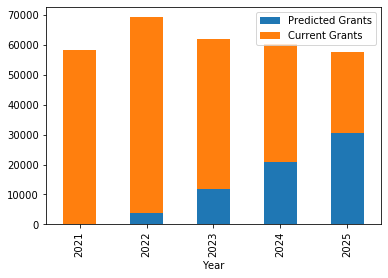

In [5]:
vests_per_year_group = {}
for year in modelled_years:
  vests_per_year_group[year] = { "Year": year, "Predicted Grants": 0, "Current Grants": 0 }

for vest in vesting_stocks:
  year = vest['date'].year
  if year in vests_per_year_group:
    if vest['predicted']:
      vests_per_year_group[year]["Predicted Grants"] += vest['est_price']
    else:
      vests_per_year_group[year]["Current Grants"] += vest['est_price']


vest_per_year = pd.DataFrame([v for k, v in vests_per_year_group.items()])
vest_per_year.plot(x=0, y=[1, 2], kind="bar", stacked=True)
print(vest_per_year)

## Cash Compensation

Now let's figure out your bonus and annual comp.

   Year       Salary       Bonus
0  2021  150000.0000  30000.0000
1  2022  154500.0000  30900.0000
2  2023  159135.0000  31827.0000
3  2024  163909.0500  32781.8100
4  2025  168826.3215  33765.2643


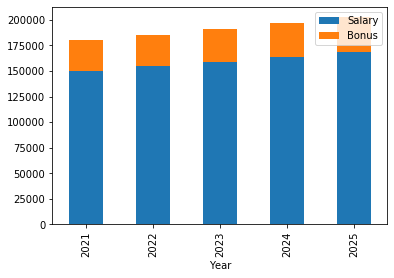

In [6]:
cash_calc_dates = [datetime(d, 12, 1) for d in modelled_years]
cash_per_year = pd.DataFrame([{ "Year": d.year, "Salary": salary_at_time(d), "Bonus": salary_at_time(d) * annual_cash_bonus_pct } for d in cash_calc_dates])
cash_per_year.plot(x=0, y=[1, 2], kind="bar", stacked=True)
print(cash_per_year)

# Total Compensation

The moment we've all been waiting for! Here's your predicted total comp. Note that this is an approximation and doesn't include information such as 401k as medical benefits.

   Year             TC
0  2021  238280.404181
1  2022  254681.573936
2  2023  253051.296198
3  2024  257014.492309
4  2025  260187.165073


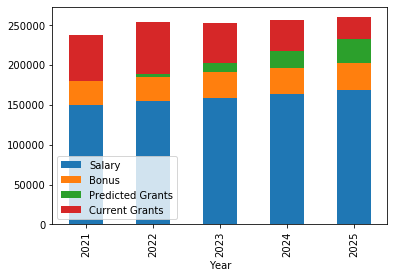

In [7]:
tc = cash_per_year.merge(vest_per_year, left_on="Year", right_on="Year")
tc.plot(x=0,  kind="bar", stacked=True)
tc['TC'] = tc[['Salary', 'Bonus', 'Predicted Grants', 'Current Grants']].sum(axis=1)
print(tc[['Year', 'TC']])